# GLMs: Binomial Models - Chimpanzee prosociality
#### Adapted from chatper 11 of Statistical Rethinking

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from theano import shared
import arviz as az
import seaborn as sns
from IPython.display import display
from PIL import Image
from scipy.special import expit as logistic
from scipy.special import softmax

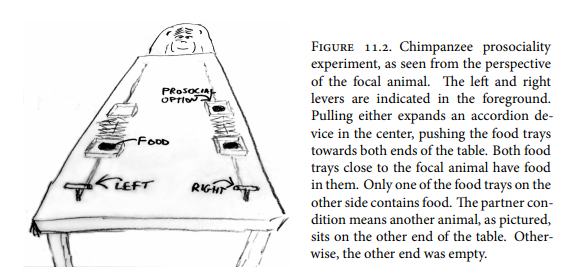

In [2]:
display(Image.open(os.path.join(os.getcwd(),r'data/chimp.png')))

#### The motivating question is whether a focal chimpanzee behaves like humans, choosing the prosocial option more often when another animal is present. In terms of linear models, we want to estimate the interaction between condition (presence or absence of another animal) and option (which side is prosocial).

#### We’re going to focus on pulled_left as the outcome to predict, with prosoc_left and condition as predictor variables. The outcome pulled_left is a 0 or 1 indicator that the focal animal pulled the left-hand lever. The predictor prosoc_left is a 0/1 indicator that the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two pieces of food. The condition predictor is another 0/1 indicator, with value 1 for the partner condition and value 0 for the control condition. We’ll want to infer what happens in each combination of prosoc_left and condition. There are four combinations: 
#### (1) prosoc_left= 0 and condition= 0: Two food items on right and no partner.
#### (2) prosoc_left= 1 and condition= 0: Two food items on left and no partner.
#### (3) prosoc_left= 0 and condition= 1: Two food items on right and partner present.
#### (4) prosoc_left= 1 and condition= 1: Two food items on left and partner present

#### Using dummy variables makes it hard to construct sensible priors. So instead let’s build an index variable containing the values 1 through 4, to index the combinations above.

In [3]:
def proc_data():
    
    def standardise(x):
        return (x - np.mean(x))/np.std(x)

    data = pd.read_csv(os.path.join(os.getcwd(),r'data/chimpdata.csv'), delimiter=";")
    data['actor'] = data.actor - 1
    data['treatment'] = data.prosoc_left + 2*data.condition
    #data = data[['actor', 'prosoc_left', 'condition', 'treatment']]
    #data.groupby("treatment").first()[["prosoc_left", "condition"]]
    return data

In [4]:
data = proc_data()

In [5]:
data.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,0,NaN,0,1,2,0,1,0,0
1,0,NaN,0,1,4,0,0,1,0
2,0,NaN,0,1,6,1,0,0,1
3,0,NaN,0,1,8,0,1,0,0
4,0,NaN,0,1,10,1,1,1,1


#### Model specification:
$$L_{i} \sim Binomial(1, p_{i})$$
$$logit(p_{i}) = \alpha_{ACTOR[i]} + \beta_{TREATMENT[i]}$$
$$\alpha_{j} \sim TBD $$
$$\beta_{k} \sim TBD $$

#### Priors are to be determined. Let's warm up for this with a thought experiment with the following basic logistic regression model:
$$L_{i} \sim Binomial(1, p_{i})$$
$$logit(p_{i}) = \alpha$$
$$\alpha \sim Normal(0, \omega)$$

#### We need to pick a value for $\omega$, to emphasise the madness of flat priors , start with something flat like $\omega = 10$.

In [6]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0, 10)
    #convert parameter to outcome scale
    p = pm.Deterministic("p", pm.math.invlogit(a))
    
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)
    
    m11_1_priors = pm.sample_prior_predictive(random_seed=8_927)
idata_11_1 = az.from_pymc3(prior=m11_1_priors)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [7]:
with pm.Model() as m11_1bis:
    a = pm.Normal("a", 0.0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=8_927)

In [8]:
idata_11_1bis = az.from_pymc3(prior=prior_11_1bis)

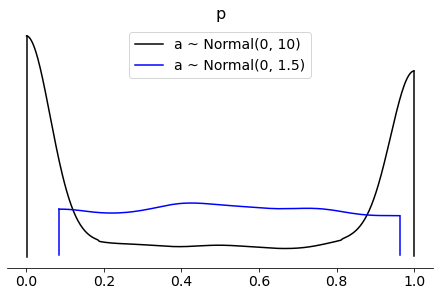

In [9]:
ax = az.plot_density(
    [idata_11_1, idata_11_1bis],
    data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)


#### Interpretation - most of the probability pass where $\omega = 10$ is clumped up near zero or one, so the model things, prior to seeing the data, that the chimps either never or always pull the left lever, which is silly.

#### A flat prior in the logit space is not a flat prior in the outcome probability space. The blue distribution in the same plot shows the same model but now with ω = 1.5. Now the prior probability on the outcome scale is rather flat. This is probably much flatter than is optimal, since probabilities near the center are more plausible.

#### We could default to using the same Normal(0,1.5) prior for the treatment effects, on the reasoning that they are also just intercepts, one intercept for each treatment. But to drive home the weirdness of conventionally flat priors, let’s see what Normal(0,10) looks like.

In [10]:
with pm.Model() as m11_2:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 10, shape=4)
    
    p = pm.math.invlogit(a + b[data.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)
    
    prior_11_2 = pm.sample_prior_predictive(random_seed = 8_927)
idata_11_2 = az.from_pymc3(prior=prior_11_2)
prior_2 = idata_11_2.prior

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [11]:
with pm.Model() as m11_3:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 0.5, shape=4)
    
    p = pm.math.invlogit(a + b[data.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)
    
    prior_11_3 = pm.sample_prior_predictive(random_seed = 8_927)
idata_11_3 = az.from_pymc3(prior=prior_11_3)
prior_3 = idata_11_3.prior

#### We are interested in what the priors suggest about the prior differences among treatments, let's get them and then plot them.

In [12]:
def get_treatment_prior_probs(priors):
    return (logistic(priors["a"] + priors["b"].sel(b_dim_0=0)), logistic(priors["a"] + priors["b"].sel(b_dim_0=1)))

In [13]:
p_treat_1, p_treat_2 = get_treatment_prior_probs(prior_2)
p_treat_1_bis, p_treat_2_bis = get_treatment_prior_probs(prior_3)

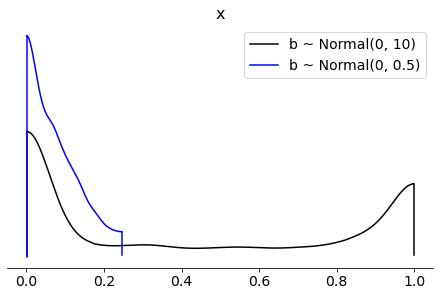

In [14]:
ax = az.plot_density([np.abs(p_treat_1 - p_treat_2).values, np.abs(p_treat_1_bis - p_treat_2_bis).values],
                    data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 0.5)"], 
                    group="prior",
                    colors=["k", "b"],
                    point_estimate=None)



#### So the wider prior sees the treatements as either completely a like or completely different. The more conservative prior is more concentrated on low absolute differences. While a difference of zero has the highest prior probability, the average prior difference is around 10%, therefore extremely large differences are less plausible.  However this is not a strong prior. If the data contain evidence of large differences, they will shine through. 

In [15]:
np.abs(p_treat_1_bis - p_treat_2_bis).mean().values

array(0.09080386)

#### Now to the full model

In [16]:
actor_idx, actors = pd.factorize(data.actor)
treat_idx, treatments = pd.factorize(data.treatment)

In [17]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0, 0.5, shape=len(treatments))
    
    actor_id = pm.intX(pm.Data("actor_id", actor_idx))
    treat_id = pm.intX(pm.Data("treat_id", treat_idx))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))
    
    pulled_left = pm.Binomial("pulled_left", 1, p , observed=data.pulled_left)
    
    trace_11_4 = pm.sample(random_seed = 8_927)
idata_11_4 = az.from_pymc3(trace_11_4)
az.summary(idata_11_4, var_names=["a", "b"])
    

<ipython-input-17-7c959f11ac93>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_4 = pm.sample(random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.443,0.336,-1.045,0.208,0.009,0.006,1397.0,1986.0,1.0
a[1],3.896,0.742,2.543,5.248,0.015,0.011,2641.0,2180.0,1.0
a[2],-0.744,0.349,-1.423,-0.108,0.009,0.006,1526.0,2414.0,1.0
a[3],-0.742,0.338,-1.370,-0.102,0.009,0.006,1537.0,2142.0,1.0
a[4],-0.438,0.337,-1.065,0.217,0.008,0.006,1618.0,2310.0,1.0
a[5],0.484,0.342,-0.194,1.111,0.008,0.006,1624.0,2312.0,1.0
a[6],1.960,0.423,1.184,2.764,0.010,0.007,1649.0,2368.0,1.0
b[0],-0.049,0.292,-0.580,0.520,0.008,0.006,1318.0,2062.0,1.0
b[1],0.478,0.296,-0.076,1.023,0.008,0.006,1343.0,2236.0,1.0
b[2],-0.389,0.290,-0.947,0.150,0.008,0.005,1421.0,2039.0,1.0


#### The first 7 parameters are the intercepts unique to each chimpanzee. Each of these expresses the tendency of each individual to pull the left lever. Let’s look at these on the outcome scale:

[Text(0, 0.0, '7'),
 Text(0, 0.825, '6'),
 Text(0, 1.65, '5'),
 Text(0, 2.4749999999999996, '4'),
 Text(0, 3.3, '3'),
 Text(0, 4.125, '2'),
 Text(0, 4.95, '1')]

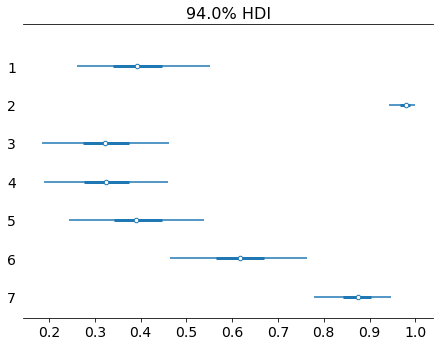

In [18]:
ax = az.plot_forest(idata_11_4, var_names=["a"], transform=logistic, combined=True)
ax[0].set_yticklabels([str(i) for i in range(7,0, -1)])

#### Each row is a chimpanzee, the numbers corresponding to the values in actor. Four of the individuals—numbers 1, 3, 4, and 5—show a preference for the right lever. Two individuals— numbers 2 and 7—show the opposite preference. Number 2’s preference is very strong indeed. If you inspect the data, you’ll see that actor 2 never once pulled the right lever in any trial or treatment. There are substantial differences among the actors in their baseline tendencies.

#### Now let’s consider the treatment effects, hopefully estimated more precisely because the model could subtract out the handedness variation among actors

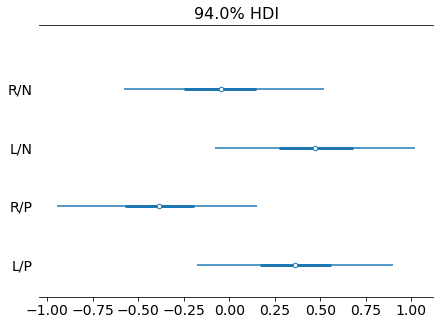

In [19]:
ax = az.plot_forest(idata_11_4, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

#### L/N means “prosocial on left / no partner.” R/P means ”prosocial on right / partner.” To understand these distributions, it’ll help to consider our expectations. What we are looking for is evidence that the chimpanzees choose the prosocial option more when a partner is present. This implies comparing the first row with the third row and the second row with the fourth row. You can probably see already that there isn’t much evidence of prosocial intention in these data. But let’s calculate the differences between no-partner/partner and make sure:

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

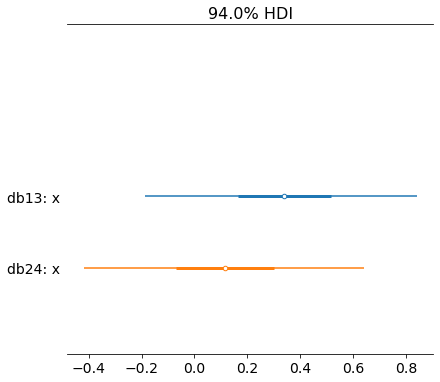

In [20]:
db13 = idata_11_4.posterior["b"].sel(b_dim_0=0) -  idata_11_4.posterior["b"].sel(b_dim_0=2)
db24 = idata_11_4.posterior["b"].sel(b_dim_0=1) -  idata_11_4.posterior["b"].sel(b_dim_0=3)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True)

#### These are the constrasts between the no-partner/partner treatments. The scale is log odds of pulling the left lever still. db13 is the difference between no-partner/partner treatments when the prosocial option was on the right. So if there is evidence of more prosocial choice when partner is present, this will show up here as a larger difference, consistent with pulling right more when partner is present. There is indeed weak evidence that individuals pulled left more when the partner was absent, but the compatibility interval is quite wide. db24 is the same difference, but for when the prosocial option was on the left. Now negative differences would be consistent with more prosocial choice when partner is present. Clearly that is not the case. If anything, individuals chose prosocial more when partner was absent. Overall, there isn’t any compelling evidence of prosocial choice in this experiment.

### Posterior prediction check

#### Start with the observed data

In [21]:
pl = data.groupby(["actor", "treatment"])["pulled_left"].mean().unstack()

In [22]:
pl

treatment,0,1,2,3
actor,,,,
0,0.333333,0.500000,0.277778,0.555556
1,1.000000,1.000000,1.000000,1.000000
2,0.277778,0.611111,0.166667,0.333333
3,0.333333,0.500000,0.111111,0.444444
4,0.333333,0.555556,0.277778,0.500000
5,0.777778,0.611111,0.555556,0.611111
6,0.777778,0.833333,0.944444,1.000000


####  Each row is an individual chimpanzee. Each column is a treatment. And the cells contain proportions of pulls that were of the left lever. Above is the first row, showing the proportions for the first actor. The model will make predictions for these values, so we can see how the posterior predictions look against the raw data. Remember that we don’t want an exact match—that would mean overfitting. But we would like to understand how the model sees the data and learn from any anomalies.


In [23]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4))*7})
    p_post = pm.sample_posterior_predictive(trace_11_4, random_seed = 8_927, var_names=['p'])['p']
p_mu = p_post.mean(0).reshape((7,4))

In [24]:
def plot_actors(ax, ax_idx, col):
    for actor in range(len(actors)):
        ax_idx.plot(
            [actor*4, actor*4+2],
            [pl.loc[actor, 0], pl.loc[actor, 2]],
            "-",
            c=col,
            alpha=alpha)
        ax_idx.plot(
            [actor*4+1, actor*4+3],
            [pl.loc[actor, 1], pl.loc[actor, 3]],
            "-",
            c=col,
            alpha=alpha)
        ax_idx.plot(
            [actor*4, actor*4+1],
            [pl.loc[actor, 0], pl.loc[actor, 1]],
            "o",
            c=col,
            fillstyle="none",
            alpha=alpha)
        ax_idx.plot(
            [actor*4+2, actor*4+3],
            [pl.loc[actor, 2], pl.loc[actor, 3]],
            "o",
            c=col,
            ms=6,
            alpha=alpha)
    ax_idx.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax_idx.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    ax_idx.set_xticks([])
    ax_idx.set_ylabel("proportion left lever", labelpad=10)
    ax_idx.set_title("observed proportions", pad=25)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


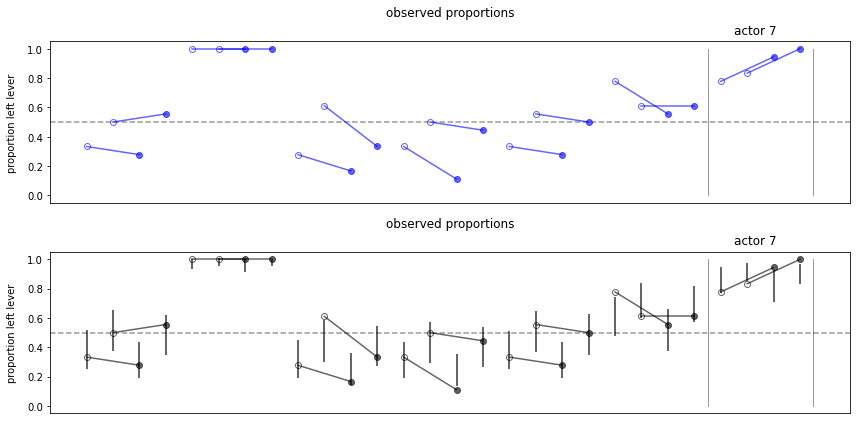

In [25]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5]*2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
plot_actors(ax, ax0, "b")

ax1.plot([range(28), range(28)], az.hdi(p_post).T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5]*2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
plot_actors(ax, ax1, "k")
plt.tight_layout()

#### The model expects almost no change when adding a partner. Most of the variation in predictions comes from the actor intercepts. Handedness seems to be the big story of this experiment. The data themselves show additional variation—some of the actors possibly respond more to the treatments than others do. We might consider a model that allows each unique actor to have unique treatment parameters.

#### The driving hypothesis of the experiment is that the prosocial option will be chosen more when the partner is present. That is an interaction effect—the effect of the prosocial option depends upon a partner being present. But we could build a model without the interaction and the use PSIS or WAIC to compare it to m11.4. You can guess from the posterior distribution of m11.4 what would happen: The simpler model will do just fine, because there doesn’t seem to be any evidence of an interaction between location of the prosocial option and the presence of the partner. Let's see

In [26]:
side = data.prosoc_left.values
cond = data.condition.values

In [ ]:
with pm.Model() as m11_5:
    a = pm.Normal("a", 0, 1.5, shape=len(actors))
    bs = pm.Normal("bs", 0, 0.5, shape=2)
    bc = pm.Normal("bc", 0, 0.5, shape=2)
    
    p = pm.math.invlogit(a[actor_idx] + bs[side] + bc[cond])
    
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=data.pulled_left)
    
    trace_11_5 = pm.sample(random_seed=8_927)

<ipython-input-27-5cc299746f78>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_11_5 = pm.sample(random_seed=8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
with m11_4:
    pm.set_data({"actor_id": actor_idx, "treat_id": treat_idx})
    trace_11_4 = pm.sample(random_seed=8_927)

In [ ]:
az.compare({"m11_4": trace_11_4, "m11_5": trace_11_5})

#### The model without the interaction is really no worse, in expected predictive accuracy, than the model with it

#### The analysis above focused on absolute effects but we can also recover relative effects. If we change a variable and say the odds of an outcome double, then we are discussing relative effects - e.g. proportional odds. 

In [ ]:
np.exp(trace_11_4["b"][:, 3] - trace_11_4["b"][:, 1]).mean()

#### "The proportional odds of switching from treatment 2 to 4". On average the switch multiplies the odds of pulling the left lever by 0.92, an 8% reduction in odds.